<a href="https://colab.research.google.com/github/guybanbo/Cloud-computing-exercises/blob/main/ex06/ex06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import requests
from firebase import firebase
from bs4 import BeautifulSoup


def fetch_page(url):
  response = requests.get(url)
  if response.status_code == 200:
   soup = BeautifulSoup(response.text, 'html.parser')
   return soup
  else:
    return None


In [1]:
!pip install requests
!pip install beautifulsoup4
!pip install firebase


Error INDEXING https://www.alibabacloud.com/forum: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
{'term': 'cloud', 'DocIDs': ['-NrkTFaf8zmnO17il21z', '-NrkTFgFqG16xOmPfdJs', '-NrkTFlqcRuFWEPKaPDw', '-NrkTFrQ4msuA7D7zXsf', '-NrkTG6AILAULyekNAsc', '-NrkTGCMsDUzQcVZAqDE', '-NrkTGS8gNpwf0Ot1iKa', '-NrkTGXjzJIeL0xeQot9', '-NrkTGrxD0jACJPuLdIc', '-NrkTH6e3NUI1IZhu63Z', '-NrkTHNWptMRvl-tGhiK', '-NrkTHTDM5t5J2TcndBW', '-NrkTHYocBH5oP8sUpMR', '-NrkTHdRdIwFw93XpTVf', '-NrkTHj1Swm_OT4ISSHY', '-NrkTHyoA8kgRjEmCSYG', '-NrkTI3O2Vxm_lG82Wv4', '-NrkTIJ8XT7Sg3U0si2B', '-NrkTIOkzxZN833v3LNq', '-NrkTIUUiR8KT-Zpa9K4', '-NrkTI_4TK4Gy2Va2_ko', '-NrkTIehF7EMPxLDjCOr', '-NrkTIkHzu3DblMeaagJ', '-NrkTIpp_TlMwc1DNKK8', '-NrkTJ4ZIapAXfy6pMhp', '-NrkTJAiacEAHbsWC2bu', '-NrkTJGjR52XvvLcUVgE', '-NrkTKGz-b3BA5GnXisQ', '-NrkTKMcgmsaT-1lAPXz', '-NrkTKSEouFusRpSsvLE', '-NrkTKXoesHEvZeBdYKw', '-NrkTKhxnKGX4L8BErDH', '-NrkTKnYaPrzyiJN9ddK', '-NrkTKt9CHMW6xTayZb0', '-NrkTL7vkM

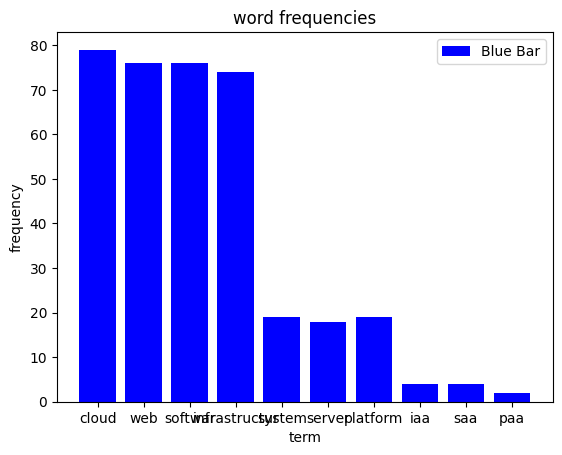

In [3]:

import requests
from firebase import firebase
from bs4 import BeautifulSoup
from collections import defaultdict
import json
import matplotlib.pyplot as plt

from urllib.parse import urljoin, urlparse

# Function to crawl a URL up to a certain depth
def crawl(url, max_depth, depth=1, visited=None):
    if visited is None:
        visited = set()

    if depth > max_depth:
        return []

    if url in visited:
        return []

    visited.add(url)

    links = []

    try:
        # Fetch the page content
        response = requests.get(url)
        response.raise_for_status()

        # Parse HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract meta description
        meta_description = soup.find('meta', {'name': 'description'})
        description = meta_description['content'] if meta_description else None

        # Extract title
        title_tag = soup.find('title')
        title = title_tag.text if title_tag else None


        # Extract links
        for link in soup.find_all('a', href=True):
            href = link['href']
            parsed_href = urlparse(href)
            domain=parsed_href.netloc
            if parsed_href.scheme and domain and (domain.endswith('.alibabacloud.com') or domain == 'alibabacloud.com'):  # Check if it's a valid URL
                absolute_url = urljoin(url, href)
                if absolute_url not in visited and absolute_url not in links:  # Check if the URL has not been visited before, added and condition for duplicates
                    links.append(absolute_url)
                    links.extend(crawl(absolute_url, max_depth, depth + 1, visited))

    except Exception as e:
        print("Error crawling {}: {}".format(url, e))

    return links

import re



def is_word(text):
    # Customize this function to define your criteria for a "word"
    # For example, you could check for alphabetic characters or length
    return text.isalpha() and len(text) > 2

def index_words(soup):
    index = {}
    words = []
    #pattern = re.compile(r'<[hp][1-6]>(.*?)<\/[hp][1-6]>', re.DOTALL)
    #matches = pattern.findall(soup.get_text())
    #words = re.findall(r"<(h\d|p)>(?:\s*(?!<(h\d|p)>|</(h\d|p)>)\w+\b)+(?:\s*)</\1>", soup.get_text())
    for tag in soup.find_all(["h1", "h2","h3", "h4", "h5", "h6", "p", "span"]):
      words.extend(filter(is_word, tag.text.split()))


    #for tag, content in matches:
      #words.append(content.strip())
    for word in words:
        word = word.lower()
        if word in index:
            index[word] += 1
        else:
            index[word] = 1
    return index

def remove_stop_words(index):
    stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at'}
    for stop_word in stop_words:
        if stop_word in index:
            del index[stop_word]
    return index

from nltk.stem import PorterStemmer

def apply_stemming(index):
    stemmer = PorterStemmer()
    stemmed_index = {}
    for word, docs in index.items():
        stemmed_word = stemmer.stem(word)
        if stemmed_word in stemmed_index:
          stemmed_index[stemmed_word] = list(set(stemmed_index[stemmed_word] + docs))
        else:
          stemmed_index[stemmed_word] = docs
    return stemmed_index



def links_enrichment (links):
  meta=[]
  for link in links:
    try:
        # Fetch the page content
        response = requests.get(link)
        response.raise_for_status()

        # Parse HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract meta description
        meta_description = soup.find('meta', {'name': 'description'})
        description = meta_description['content'] if meta_description else None

        # Extract title
        title_tag = soup.find('title')
        title = title_tag.text if title_tag else None

        meta.append( {"link" : link,
                "title" : title,
                "description" : description} )
    except Exception as e:
        meta.append( {"link" : link,
                "title" : None,
                "description" : None})
        print(e)
  return meta


def create_index(links):
    dictionary=["cloud", "web", "software", "infrastructure", "saas", "iaas", "paas", "server",  "system", "platform"]
    word_index = {}
    for id,data in links.items():
      # Fetch the page content
      try:
        response = requests.get(data)
        response.raise_for_status()

       # Parse HTML
        soup = BeautifulSoup(response.text, 'html.parser')
        words = index_words(soup)
        for word in words:
          if word in dictionary:
         # Append the link(id) to the list of links for each word
            word_index.setdefault(word, []).append(id)
      except Exception as e:
          print("Error INDEXING {}: {}".format(data, e))
    return word_index





# Start crawling from the root URL
root_url = "https://www.alibabacloud.com/"
max_depth = 1
crawled_links = crawl(root_url, max_depth)
#links = links_enrichment(crawled_links)
url = "https://ex06-24336-default-rtdb.europe-west1.firebasedatabase.app/"
FBconn = firebase.FirebaseApplication(url,None)
for link in crawled_links:
  FBconn.post('/pages/',link)
result = FBconn.get('/pages', None)
index = create_index(result)
stemmed_Index=apply_stemming(index)
for term,DocIDs in stemmed_Index.items():
  data = {"term":term, "DocIDs": DocIDs}
  print(data)
  FBconn.post('/index/',data)
x=[]
y=[]
for term,DocIDs in stemmed_Index.items():
  x.append(term)
  y.append(len(DocIDs))

# Colors: https://matplotlib.org/api/colors_api.html

plt.bar(x, y, label="Blue Bar", color='b')
plt.plot()

plt.xlabel("term")
plt.ylabel("frequency")
plt.title("word frequencies")
plt.legend()
plt.show()


#url = "https://search-engine-568ee-default-rtdb.europe-west1.firebasedatabase.app"








In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stemmed_word = stemmer.stem("started")
print(stemmed_word)

start


In [ ]:
from firebase import firebase

